1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd 
import numpy as np
import datetime as dt

In [10]:
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
x = max(data['BX_COUNTER']) - min(data['BX_COUNTER']) +1

print("There are", x, "BX number in a ORBIT")

There are 3564 BX number in a ORBIT


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [5]:
data['TIME'] = data['TDC_MEAS']*(25/30) + data['BX_COUNTER']*25 + data['ORBIT_CNT']*x*25  #non concluso eh
data['TIME_datatime'] = pd.to_datetime(data["TIME"]-data["TIME"][0])
data


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,TIME_datatime
0,1,0,123,3869200167,2374,26,3.447457e+14,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,3.447457e+14,1970-01-01 00:00:00.000000000
2,1,0,63,3869200167,2553,28,3.447457e+14,1970-01-01 00:00:00.000004476
3,1,0,64,3869200167,2558,19,3.447457e+14,1970-01-01 00:00:00.000004594
4,1,0,64,3869200167,2760,25,3.447457e+14,1970-01-01 00:00:00.000009649
...,...,...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0,3.447459e+14,1970-01-01 00:00:00.177251528
199996,1,0,62,3869202157,76,2,3.447459e+14,1970-01-01 00:00:00.177251530
199997,1,1,2,3869202157,94,15,3.447459e+14,1970-01-01 00:00:00.177251990
199998,1,1,1,3869202157,96,13,3.447459e+14,1970-01-01 00:00:00.177252039


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
N = data.index.stop
data_taking_duration = data['TIME'][N-1]-data['TIME'][0]
print("The data taking lasted", data_taking_duration*10**(-9), "s")


The data taking lasted 0.177252319125 s


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
data.groupby(['TDC_CHANNEL']).size().sort_values(ascending = False)
data.head(3)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,TIME_datatime
0,1,0,123,3869200167,2374,26,3.447457e+14,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,3.447457e+14,1970-01-01 00:00:00.000000000
2,1,0,63,3869200167,2553,28,3.447457e+14,1970-01-01 00:00:00.000004476


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [8]:
data['ORBIT_CNT'].ne(0)
orbits = len(data['ORBIT_CNT'].ne(0))
print("the number of non empty orbits is:", orbits)

the number of non empty orbits is: 200000


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
mask = data['TDC_CHANNEL']==139 
data_mask = data[mask]
number = data_mask['ORBIT_CNT'].nunique()
print("the number of unique non-empty orbits from TDC_CHANNEL=139 is:", number)


the number of unique non-empty orbits from TDC_CHANNEL=139 is: 1987


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [1]:
fpga0 = data[data['FPGA'] == 0]
fpga1 = data[data['FPGA'] == 1]

series0 = pd.Series(fpga0['ORBIT_CNT'], index=tuple(data['TDC_CHANNEL'].tolist()), dtype=float)
series1 = pd.Series(fpga1['ORBIT_CNT'], index=tuple(data['TDC_CHANNEL'].tolist()), dtype=float)

NameError: name 'data' is not defined

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

array([[<AxesSubplot:title={'center':'TDC_CHANNEL'}>]], dtype=object)

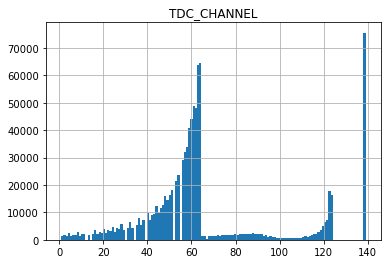

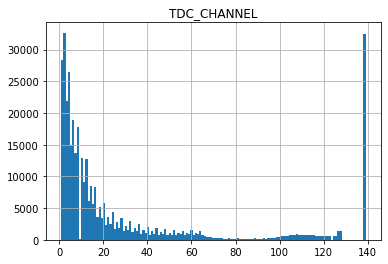

In [68]:
fpga0.hist("TDC_CHANNEL",bins=data['TDC_CHANNEL'].max())
fpga1.hist("TDC_CHANNEL",bins=data['TDC_CHANNEL'].max())